In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Unsupervised Learning

In [ ]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.colors import to_hex

### Preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/online_purchase.csv",encoding="unicode_escape")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# drop null rows
df.dropna(subset=["CustomerID"],inplace=True)

In [ ]:
# droping canceled orders
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
   
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
   
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break           

df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True) 

In [ ]:
df_cleaned.to_csv("cleaned_dataset.csv")

In [ ]:
df_cleaned = pd.read_csv("cleaned_dataset.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_cleaned.head(10)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,0
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,0
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
5,5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom,0
6,6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom,0
7,7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,0
8,8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,0
9,9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom,0


In [ ]:
df_cleaned["Amount"] = df_cleaned["Quantity"]*df_cleaned["UnitPrice"]

In [ ]:
# creating RFM table
todays = dt.datetime(2021,4,22,16,40)
df_cleaned["InvoiceDate"] = pd.to_datetime(df_cleaned.InvoiceDate)
df_modified = df_cleaned.groupby('CustomerID').agg({'InvoiceDate': lambda x: (todays - x.max()).days, # Recency
                                        'InvoiceNo': lambda x: len(x),      # Frequency
                                        "Amount": lambda x: x.sum()}) # Monetary Value

In [ ]:
df_modified.rename(inplace=True,columns={"InvoiceDate":"Recency","InvoiceNo":"Frequency","Amount":"Monetary_value"})

In [ ]:
df_modified.head()

,Recency,Frequency,Monetary_value
CustomerID,,,
12346.0,3747,1,77183.60
12347.0,3424,182,4310.00
12348.0,3497,31,1797.24
12349.0,3440,73,1757.55
12350.0,3732,17,334.40


In [ ]:
scale = preprocessing.StandardScaler()
XX = scale.fit_transform(df_modified)
partition = int(len(XX)*4/5)
XX_train, XX_test = XX[:partition], XX[partition:]

### Visualization of dataset

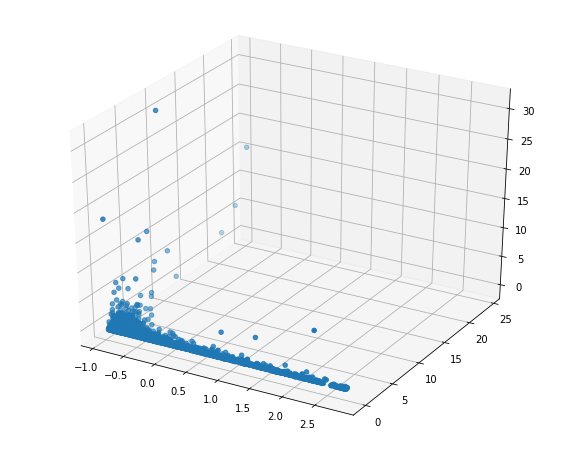

In [ ]:
plt.figure(figsize=(9,7))
# plt.scatter(XX_train[:,0],XX_train[:,2])

axs = plt.axes(projection="3d")
axs.scatter3D(XX_train[:,0],XX_train[:,1],XX_train[:,2])

## K-means

Finding appropriate value of 'k'

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 13)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(XX_train)
 
    distortions.append(sum(np.min(cdist(XX_train, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / XX_train.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(XX_train, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / XX_train.shape[0]
    mapping2[k] = kmeanModel.inertia_

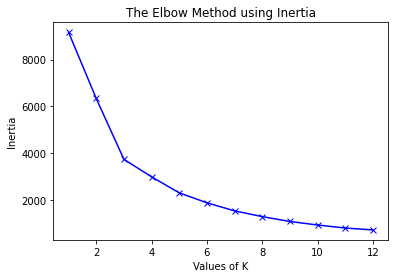

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(XX_train)
y_pred = kmeans.predict(XX_test)

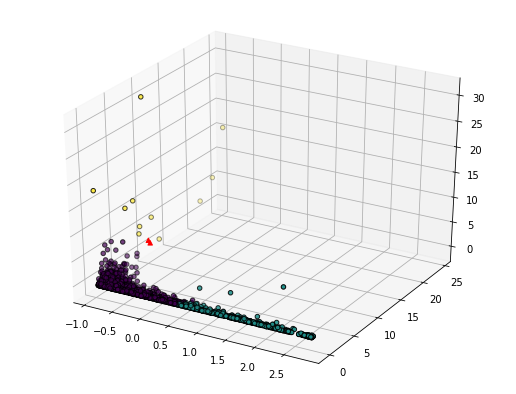

In [ ]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

plt.figure(figsize=(9,7))
axs = plt.axes(projection="3d")
axs.scatter3D(XX_train[:,0],XX_train[:,1],XX_train[:,2],c=labels.astype(float),edgecolor="k")
axs.scatter3D(centroids[0,:],centroids[1,:],centroids[2,:],color="red",marker="^")
plt.show()

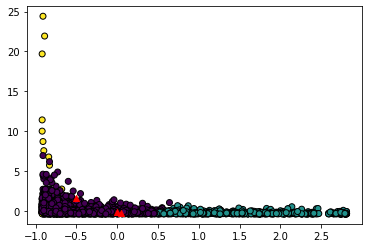

In [ ]:
plt.figure(figsize=(9,7))
plt.scatter(XX_train[:,0],XX_train[:,1],c=labels.astype(float),edgecolor="k")
plt.scatter(centroids[0,:],centroids[1,:],color="red",marker="^")

## Hierarchical Clustering

In [ ]:
from scipy.cluster import hierarchy as shc
from sklearn.cluster import AgglomerativeClustering 

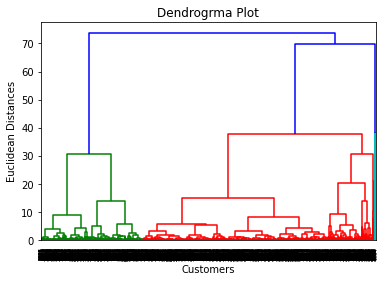

In [ ]:
dendrogram = shc.dendrogram(shc.linkage(XX_train,method="ward"))
# plt.figure(figsize=(10,8))
plt.title("Dendrogrma Plot")  
plt.ylabel("Euclidean Distances")  
plt.xlabel("Customers")  
plt.show()

In [ ]:
hc= AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
y_pred_hc = hc.fit_predict(XX)

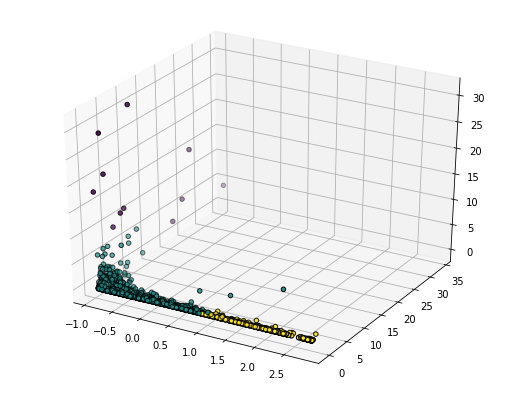

In [ ]:
plt.figure(figsize=(9,7))
axs = plt.axes(projection="3d")
axs.scatter3D(XX[:,0],XX[:,1],XX[:,2],c=y_pred_hc.astype(float),edgecolor="k")
plt.show()

# Supervised Learning

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sample-orders.csv",encoding = 'unicode_escape')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   order_date   5009 non-null   object
 1   order_id     5009 non-null   object
 2   customer     5009 non-null   object
 3   grand_total  5009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 156.7+ KB


In [ ]:
dataset["order_date"] = pd.to_datetime(dataset["order_date"])
dataset.head(5)

,order_date,order_id,customer,grand_total
0,2011-09-07,CA-2011-100006,Dennis Kane,378
1,2011-07-08,CA-2011-100090,Ed Braxton,699
2,2011-03-14,CA-2011-100293,Neil Franzsisch,91
3,2011-01-29,CA-2011-100328,Jasper Cacioppo,4
4,2011-04-08,CA-2011-100363,Jim Mitchum,21


In [ ]:
today = dt.datetime(2021,4,20)
RFM_Table = dataset.groupby('customer').agg({'order_date': lambda x: (today - x.max()).days, # Recency
                                        'order_id': lambda x: len(x),      # Frequency
                                        'grand_total': lambda x: x.sum()}) # Monetary Value


In [ ]:
# RMF_Table.head(5)
print(type(RFM_Table["order_date"]))

<class 'pandas.core.series.Series'>


In [ ]:
RFM_Table["order_date"] = RFM_Table["order_date"].astype(int)
RFM_Table.rename(inplace=True,columns={"order_date":"recency","order_id":"frequency","grand_total":"monetary_value"})

In [ ]:
RFM_Table.head(5)

,recency,frequency,monetary_value
customer,,,
Aaron Bergman,2717,3,887
Aaron Hawkins,2314,7,1744
Aaron Smayling,2390,7,3050
Adam Bellavance,2356,8,7756
Adam Hart,2336,10,3249


In [ ]:
quantiles = RFM_Table.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,2332.0,5.0,1145.0
0.50,2377.0,6.0,2257.0
0.75,2485.0,8.0,3784.0


In [ ]:
# print(type(quantiles))
quantiles = quantiles.to_dict(orient="dict")
quantiles

{'frequency': {0.25: 5.0, 0.5: 6.0, 0.75: 8.0},
 'monetary_value': {0.25: 1145.0, 0.5: 2257.0, 0.75: 3784.0},
 'recency': {0.25: 2332.0, 0.5: 2377.0, 0.75: 2485.0}}

In [ ]:
def class_assign(val,param,quantile):
  if val <= quantile[param][0.25]:
    return 1
  elif val <= quantile[param][0.5]:
    return 2
  elif val <= quantile[param][0.75]:
    return 3
  else:
    return 4

In [ ]:
RFM_Table["R"] = RFM_Table["recency"].apply(class_assign,args=("recency",quantiles,))
RFM_Table["F"] = RFM_Table["frequency"].apply(class_assign,args=("frequency",quantiles,))
RFM_Table["M"] = RFM_Table["monetary_value"].apply(class_assign,args=("monetary_value",quantiles,))
RFM_Table.head(5)

,recency,frequency,monetary_value,R,F,M
customer,,,,,,
Aaron Bergman,2717,3,887,4,1,1
Aaron Hawkins,2314,7,1744,1,3,2
Aaron Smayling,2390,7,3050,3,3,3
Adam Bellavance,2356,8,7756,2,3,4
Adam Hart,2336,10,3249,2,4,3


In [ ]:
RFM_Table["Label"] = RFM_Table[["R","F","M"]].sum(axis=1)
RFM_Table.head(5)

,recency,frequency,monetary_value,R,F,M,Label
customer,,,,,,,
Aaron Bergman,2717,3,887,4,1,1,6
Aaron Hawkins,2314,7,1744,1,3,2,6
Aaron Smayling,2390,7,3050,3,3,3,9
Adam Bellavance,2356,8,7756,2,3,4,9
Adam Hart,2336,10,3249,2,4,3,9


## VISUALIZATION

{3: 31, 4: 41, 5: 78, 6: 150, 7: 130, 8: 143, 9: 116, 10: 69, 11: 26, 12: 9}


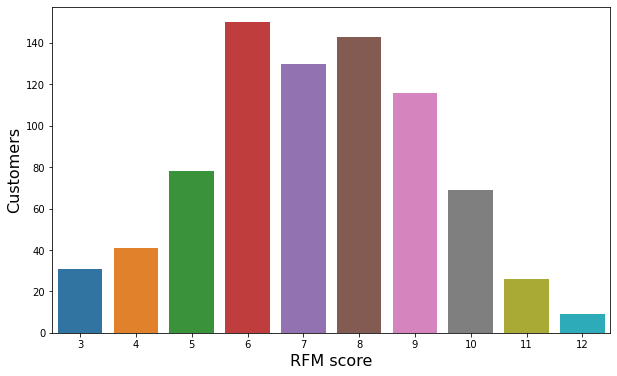

In [ ]:
labels = RFM_Table.groupby("Label").size()
labels = labels.to_dict()
print(labels)
plt.figure(figsize=(10,6))
plt.xlabel("RFM score",size=16)
plt.ylabel("Customers",size=16)
sns.barplot(x=list(labels.keys()),y=list(labels.values()))

# BELOW IS A VERY IMPORTANT CELL. DO NOT DELETE IT.

In [ ]:
# 1st definition of model
  # epochs = 200 (i think it's okay)
  # n_x = [64,128,128,128,12] (this works good enough with train accuracy=95% and test accuracy=82%) 

# 2nd definition of model (best till now)
  # epochs = 100
  # n_x = [64(0.2 drop),64(0.2 drop),128(0.1 drop),128(0.1 drop),12]

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [ ]:
def convert_labels(labels):
  """
    params:
      labels: a dataframe consisting labels given to every customer in dataset
    output: a numpy array(sparse matrix) consisting of 0's and 1's with shape (len(labels),12)
  """
  y = np.zeros((labels.shape[0],12))
  labels = labels.to_numpy(copy=False)
  for i in range(len(labels)):
    y[i][labels[i]-1] = 1
  return y

In [ ]:
# extracting data from RFM table
# X = RFM_Table[["recency","frequency","monetary_value"]].copy()
X = RFM_Table[["R","F","M"]].copy().to_numpy()
# X = preprocessing.scale(X)
Y = RFM_Table[["Label"]].copy()
Y = convert_labels(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
Y.shape

(793, 12)

In [ ]:
# model
model = Sequential()
model.add(Dense(64,input_dim=3,activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(64,activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(rate=0.1))
model.add(Dense(128,activation="relu"))
model.add(Dropout(rate=0.1))
model.add(Dense(12,activation="softmax"))
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
model.fit(X_train,y_train,epochs=100,batch_size=20)

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 2.3808 - accuracy: 0.1340
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 2.0382 - accuracy: 0.2474
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 1.9974 - accuracy: 0.2341
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 1.8852 - accuracy: 0.2646
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 1.8829 - accuracy: 0.2428
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 1.8294 - accuracy: 0.2657
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 1.7279 - accuracy: 0.2846
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 1.7060 - accuracy: 0.3078
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 1.6234 - accuracy: 0.3284
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 1.5047 - accuracy: 0.3716
Epoch 11/

In [ ]:
import pickle
model.save("customer_segmentation_RFM.h5")

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 64)                256       
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 128)             

In [ ]:
trained_model = load_model("customer_segmentation_RFM.h5")
loss,accuracy = trained_model.evaluate(X_test,y_test)
print(loss,"\n",accuracy*100,"%")

5/5 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.9434
0.12700311839580536 
 94.33962106704712 %
